In [ ]:
import sys
import pickle
sys.path.append("..")

import torch
from torch.optim import AdamW
from transformers import T5Tokenizer
from torch.utils.data import DataLoader
from transformers import T5ForConditionalGeneration

from datasets import load_dataset
from transformers import get_linear_schedule_with_warmup

from scripts.global_vars import (
    DEVICE, 
    MAX_TURNS,
    BATCH_SIZE, 
    MODEL_NAME,
    USE_SAVE_CHECKPOINT,
    MAX_LENGTH_ENCODER_ACTION, 
    MAX_LENGTH_DECODER_ACTION
)

from scripts.pytorch.training import train_model
from scripts.pytorch.inference import inference_model
from scripts.utils import find_zero_percentage, plot_model_performance
from scripts.preprocessing.action import ActionDataset, get_evaluation_score

___

### **STAGE 1. Dataset Loading and Preprocessing**

___

In [2]:
dataset = load_dataset("multi_woz_v22", trust_remote_code=True)

train_data = dataset['train']
val_data = dataset['validation']

In [3]:
tokenizer = T5Tokenizer.from_pretrained(
    legacy=True,
    pretrained_model_name_or_path=MODEL_NAME
)

train_action_dataset = ActionDataset(
    data=dataset['train'],
    tokenizer=tokenizer,
    max_turns=MAX_TURNS,
    max_output_len=MAX_LENGTH_DECODER_ACTION,
    max_input_len=MAX_LENGTH_ENCODER_ACTION,
    delex=True
    
)

valid_action_dataset = ActionDataset(
    data=dataset['validation'],
    tokenizer=tokenizer,
    max_turns=MAX_TURNS,
    max_output_len=MAX_LENGTH_DECODER_ACTION,
    max_input_len=MAX_LENGTH_ENCODER_ACTION,
    delex=True
)

train_loader_action = DataLoader(train_action_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader_action = DataLoader(valid_action_dataset, batch_size=BATCH_SIZE)

batch = next(iter(train_loader_action))
print("Inputs IDs shape:", batch['encoder_input_ids'].shape)
print("Action IDs shape:", batch['decoder_input_ids'].shape)

Processing dialogues: 100%|██████████| 1000/1000 [00:00<00:00, 1303.20it/s]


Inputs IDs shape: torch.Size([256, 64])
Action IDs shape: torch.Size([256, 32])


In [4]:
train_encoder_zero = find_zero_percentage(train_loader_action, "encoder_input_ids", MAX_LENGTH_ENCODER_ACTION)
train_decoder_zero = find_zero_percentage(train_loader_action, "decoder_input_ids", MAX_LENGTH_DECODER_ACTION)
valid_encoder_zero = find_zero_percentage(valid_loader_action, "encoder_input_ids", MAX_LENGTH_ENCODER_ACTION)
valid_decoder_zero = find_zero_percentage(valid_loader_action, "decoder_input_ids", MAX_LENGTH_DECODER_ACTION)

In [5]:
print(
    "Train Encoder Zero Percentage:", train_encoder_zero * 100,
    "\nTrain Decoder Zero Percentage:", train_decoder_zero * 100,
    "\nValid Encoder Zero Percentage:", valid_encoder_zero * 100,
    "\nValid Decoder Zero Percentage:", valid_decoder_zero * 100
)

Train Encoder Zero Percentage: 33.785223960876465 
Train Decoder Zero Percentage: 37.41556704044342 
Valid Encoder Zero Percentage: 32.38596022129059 
Valid Decoder Zero Percentage: 36.70688271522522


___

### **STAGE 2. Model Training**

___

In [6]:
num_epochs = 5
num_training_steps = len(train_loader_action) * num_epochs
num_warmup_steps = num_training_steps // 10

action_model = T5ForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME
).to(DEVICE)

optimizer = AdamW(
    action_model.parameters(),
    lr=1e-3,
    eps=1e-8
)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [8]:
if not USE_SAVE_CHECKPOINT:
    action_model = train_model(
        action_model,
        optimizer,
        scheduler,
        train_loader_action,
        valid_loader_action,
        num_epochs=num_epochs,
        device=DEVICE,
        save="../../models/multixoz_action_model.pth"
    )
    
else:
    action_model.load_state_dict(torch.load("../../models/multixoz_action_model.pth"))


Epoch 1/5
--------------------------------------------------


Validation: 100%|██████████| 58/58 [00:07<00:00,  7.73it/s]


Training   - Loss: 0.8648
Validation - Loss: 0.0658
LR: 8.89e-04

Epoch 2/5
--------------------------------------------------


Validation: 100%|██████████| 58/58 [00:08<00:00,  6.89it/s]


Training   - Loss: 0.0705
Validation - Loss: 0.0452
LR: 6.67e-04

Epoch 3/5
--------------------------------------------------


Validation: 100%|██████████| 58/58 [00:07<00:00,  7.72it/s]


Training   - Loss: 0.0539
Validation - Loss: 0.0403
LR: 4.44e-04

Epoch 4/5
--------------------------------------------------


Validation: 100%|██████████| 58/58 [00:07<00:00,  7.30it/s]


Training   - Loss: 0.0475
Validation - Loss: 0.0383
LR: 2.22e-04

Epoch 5/5
--------------------------------------------------


Validation: 100%|██████████| 58/58 [00:08<00:00,  7.19it/s]


Training   - Loss: 0.0439
Validation - Loss: 0.0369
LR: 0.00e+00


___

### **STAGE 3. Model Evaluation**

___

In [9]:
if not USE_SAVE_CHECKPOINT:    
    generated_action_train = inference_model(
        action_model, 
        tokenizer, 
        train_action_dataset.inputs, 
        MAX_LENGTH_ENCODER_ACTION, 
        MAX_LENGTH_DECODER_ACTION, 
        DEVICE,
        batch_size=1024,
        save="../../data/generated_outputs_train_action.pkl"
    ) 

    generated_action_valid = inference_model(
        action_model, 
        tokenizer, 
        valid_action_dataset.inputs, 
        MAX_LENGTH_ENCODER_ACTION, 
        MAX_LENGTH_DECODER_ACTION, 
        DEVICE,
        batch_size=1024,
        save="../../data/generated_outputs_valid_action.pkl"
    ) 
    
else:
    generated_outputs_train = pickle.load(open("../../data/generated_outputs_train_action.pkl", "rb"))
    generated_outputs_valid = pickle.load(open("../../data/generated_outputs_valid_action.pkl", "rb"))

Inference: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]


In [ ]:
if not USE_SAVE_CHECKPOINT:
    train_evaluation = get_evaluation_score(
        generated_action_train, 
        train_action_dataset.actions,
        save="../../data/train_evaluation_action.pkl"
    )
    valid_evaluation = get_evaluation_score(
        generated_action_valid, 
        valid_action_dataset.actions,
        save="../../data/valid_evaluation_action.pkl"
    )
    
else:
    train_evaluation = pickle.load(open("../../data/train_evaluation_action.pkl", "rb"))
    valid_evaluation = pickle.load(open("../../data/valid_evaluation_action.pkl", "rb"))

In [11]:
print("BLEU Score Train:", train_evaluation["bleu_score"])
print("SER Score Train:", train_evaluation["ser_score"])
print("BLEU Score Valid:", valid_evaluation["bleu_score"])
print("SER Score Valid:", valid_evaluation["ser_score"])

BLEU Score Train: 0.7472834158764451
SER Score Train: 0.8694228960234199
BLEU Score Valid: 0.7459993093546742
SER Score Valid: 0.865175040987559


In [25]:
index = 20
inputs = train_action_dataset.inputs[index]

generated_action = inference_model(
    action_model,
    tokenizer,
    inputs,
    MAX_LENGTH_ENCODER_ACTION,
    MAX_LENGTH_DECODER_ACTION,
    DEVICE
)

print("\nUser Inputs:", inputs)
print("Generated Action:", generated_action)
print("True Action:", train_action_dataset.actions[index])

Inference: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


User Inputs: SYS: The booking was unsuccessful. would you like another day or a shorter stay? USER: How about for [BOOKSTAY] nights?
Generated Action: Hotel-Inform(bookstay=BOOKSTAY)
True Action: Hotel-Inform(bookstay=BOOKSTAY)


___

### **STAGE 4. Result Visualization**

___

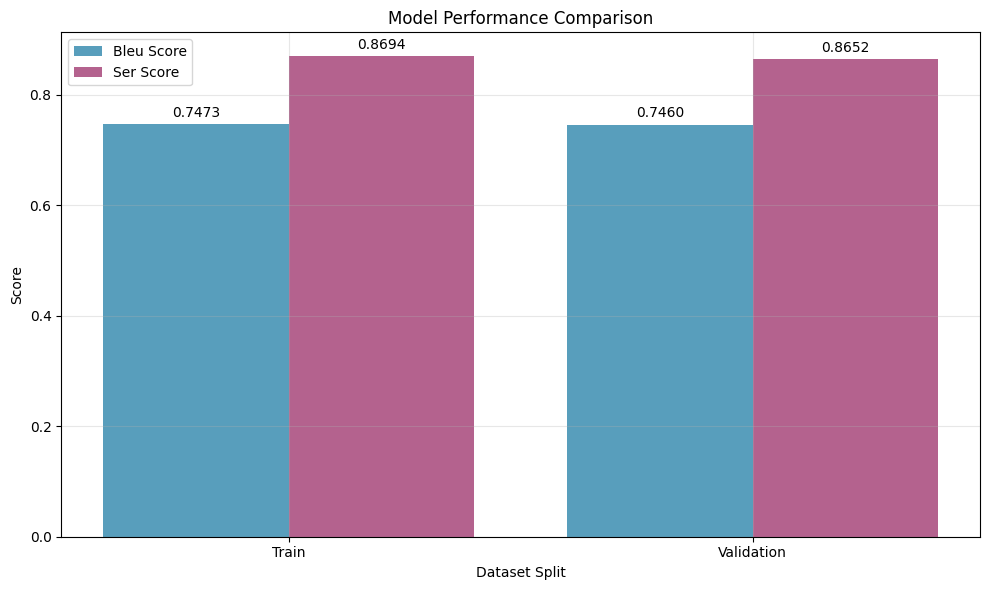

In [28]:
plot_model_performance(train_evaluation, valid_evaluation)